In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

"""
imagenet_2012_challenge_label_map_proto.pbtxt

entry {
  target_class: 449
  target_class_string: "n01440764"
}
entry {
  target_class: 450
  target_class_string: "n01443537"
}
"""
"""
imagenet_synset_to_human_label_map.txt
n00004475	organism, being
n00005787	benthos
n00006024	heterotroph
n00006484	cell
n00007846	person, individual, someone, somebody, mortal, soul
n00015388	animal, animate being, beast, brute, creature, fauna
n00017222	plant, flora, plant life
"""

'\nimagenet_synset_to_human_label_map.txt\nn00004475\torganism, being\nn00005787\tbenthos\nn00006024\theterotroph\nn00006484\tcell\nn00007846\tperson, individual, someone, somebody, mortal, soul\nn00015388\tanimal, animate being, beast, brute, creature, fauna\nn00017222\tplant, flora, plant life\n'

In [2]:
# define dictionary
class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        # read line by line
        for line in proto_as_ascii_lines :
            # delete \n
            line=line.strip('\n')
            # delete \t
            parsed_items = line.split('\t')
            # get uid
            uid = parsed_items[0]
            # get string
            human_string = parsed_items[1]
            # save to dictionary
            uid_to_human[uid] = human_string

        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):
                #获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                #获取编号字符串n********
                target_class_string = line.split(': ')[1]
                #保存分类编号1-1000与编号字符串n********映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]

        #建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    #传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]

In [3]:
# import trained model
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

images/p1.jpg


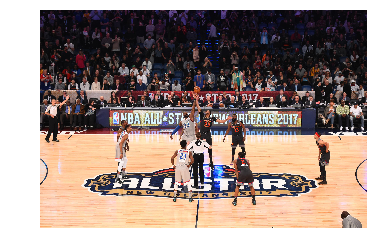

unicycle, monocycle (score = 0.24054)
basketball (score = 0.13939)
balance beam, beam (score = 0.11712)
horizontal bar, high bar (score = 0.11096)
volleyball (score = 0.06381)

images/p2.jpg


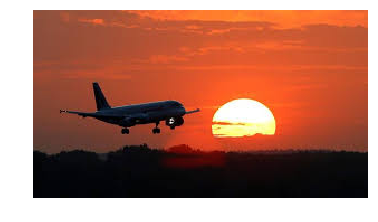

airliner (score = 0.69215)
space shuttle (score = 0.15397)
wing (score = 0.02916)
warplane, military plane (score = 0.00556)
airship, dirigible (score = 0.00186)

images/p3.jpg


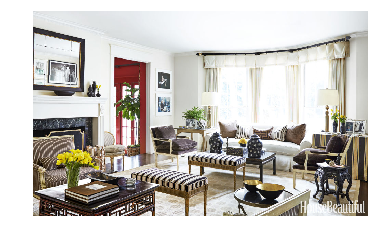

restaurant, eating house, eating place, eatery (score = 0.19561)
window shade (score = 0.19318)
dining table, board (score = 0.07322)
patio, terrace (score = 0.07291)
sliding door (score = 0.03500)

images/p4.jpg


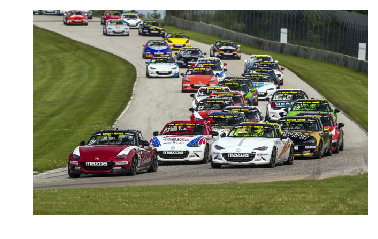

racer, race car, racing car (score = 0.71463)
sports car, sport car (score = 0.16358)
passenger car, coach, carriage (score = 0.06613)
car wheel (score = 0.00419)
pickup, pickup truck (score = 0.00183)



In [4]:
with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # go through all files
    # save files under folder: images
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # load images
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data})
            predictions = np.squeeze(predictions) # change image to 1 dimension

            # pring image and image path
            image_path = os.path.join(root,file)
            print(image_path)
            # show image
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # rank
            top_k = predictions.argsort()[-5:][::-1]
            node_lookup = NodeLookup()
            for node_id in top_k:     
                #获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                #获取该分类的置信度
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()